In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28)
        self.fc2 = nn.Linear(28, 28)
        self.fc3 = nn.Linear(28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    model.to(device)
    
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            

def get_train_loader(batch_size=256):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    loader_kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **loader_kwargs)
    return train_loader

def extract_activations_and_losses(model, data_loader):
    model.eval()
    model.to(device)
    all_activations = []
    all_losses = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            x = data.view(-1, 28 * 28)
            h1 = F.relu(model.fc1(x))
            h2 = F.relu(model.fc2(h1))
            output = model.fc3(h2)

            h1_binary = (h1 > 0).float()
            h2_binary = (h2 > 0).float()

            losses = F.cross_entropy(output, target, reduction='none')
            activation_pattern = torch.cat([h1_binary, h2_binary], dim=1)
            all_activations.append(activation_pattern.cpu())
            all_losses.append(losses)
    
    return torch.cat(all_activations).numpy(), torch.cat(all_losses).numpy()

model = SimpleNN()
train_loader = get_train_loader()
train_model(model, train_loader)
activations, losses = extract_activations_and_losses(model, train_loader)

X_test, X_stop_test, y_test, y_stop_test = train_test_split(
    activations, 
    losses, 
    test_size=0.1,
    random_state=42
)
test_data = lgb.Dataset(X_test, label=y_test)
stop_test_data = lgb.Dataset(X_stop_test, label=y_stop_test, reference=test_data)
print(f"\nExtracted {len(activations)} samples for tree construction. Building NAP tree...")
start_time = time.time()

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': ['rmse', 'mae'],  # Multiple metrics for better monitoring
    
    # Tree structure - more complex for better fitting
    'max_depth': -1,  # No limit, let min_data_in_leaf control
    'num_leaves': 4096,  # Increased from 2048 for more complex trees
    'min_data_in_leaf': 1,  # Reduced from 3 for more granular splits
    'min_sum_hessian_in_leaf': 1e-6,  # Reduced for more sensitive splits
    'min_gain_to_split': 0.0,  # Allow all beneficial splits
    
    # Feature selection - use all features aggressively
    'feature_fraction': 1.0,
    'feature_fraction_bynode': 1.0,
    'bagging_fraction': 0.9,  # Slight bagging for regularization
    'bagging_freq': 1,
    
    # Learning parameters - slower but more thorough
    'learning_rate': 0.005,  # Reduced for more iterations
    
    # Regularization - lighter since we want to fit well
    'lambda_l1': 0.01,  # Reduced L1
    'lambda_l2': 0.01,  # Reduced L2
    'alpha': 0.9,  # Huber loss parameter for robustness
    
    # Computational
    'num_threads': -1,
    'force_row_wise': True,
    'verbosity': 1,
    'seed': 42,
    'deterministic': True,
    
    # Advanced options for better performance
    'boost_from_average': True,
    'is_unbalance': False,
    'max_bin': 511,  # Increased for better discretization
    'bin_construct_sample_cnt': 200000,  # Use more samples for binning
}

model_lgb = lgb.train(
    params, 
    test_data, 
    num_boost_round=5000,
    valid_sets=[stop_test_data],
    valid_names=['stop_test_data'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100),
        lgb.reset_parameter(learning_rate=lambda iter: 0.005 * (0.99 ** (iter // 100)))
    ]
)

print(f"LightGBM model built in {time.time() - start_time:.2f} seconds")


Extracted 60000 samples for tree construction. Building NAP tree...
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 56
[LightGBM] [Info] Start training from score 0.138925
Training until validation scores don't improve for 100 rounds
[100]	stop_test_data's rmse: 0.566184	stop_test_data's l1: 0.207038
[200]	stop_test_data's rmse: 0.566421	stop_test_data's l1: 0.199949
Early stopping, best iteration is:
[139]	stop_test_data's rmse: 0.565218	stop_test_data's l1: 0.203617
LightGBM model built in 155.10 seconds


Dataset has 60000 training samples
With batch size 256, there are 235 steps per epoch

Training model for 11 steps (~0.05 epochs)...
Building LightGBM model with 60000 samples...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[580]	stop_test_data's rmse: 0.235584	stop_test_data's l1: 0.160404
LightGBM model built in 436.76 seconds
Results for 11 steps (~0.05 epochs):
  Model Accuracy: 0.4644
  LightGBM Coverage: 0.000
  Baseline Coverage: 0.037

Training model for 23 steps (~0.10 epochs)...
Building LightGBM model with 60000 samples...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[728]	stop_test_data's rmse: 0.36233	stop_test_data's l1: 0.235256
LightGBM model built in 645.89 seconds
Results for 23 steps (~0.10 epochs):
  Model Accuracy: 0.6263
  LightGBM Coverage: 0.076
  Baseline Coverage: 0.099

Training model for 58 steps (~0.25 epochs)...
Building LightGBM model with 60000 samples

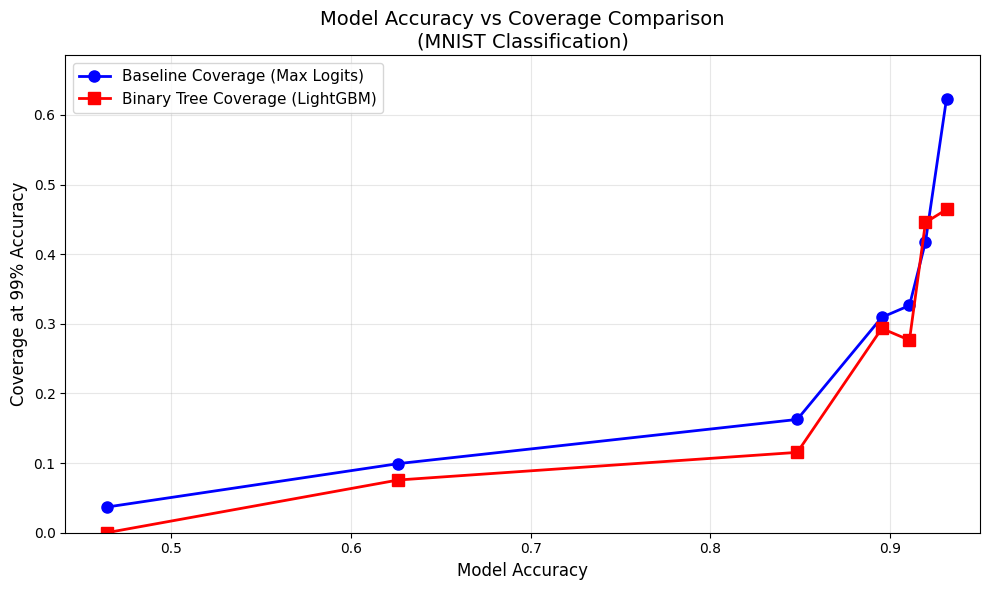


Plot saved as 'mnist_accuracy_vs_coverage_comparison.png'


<Figure size 640x480 with 0 Axes>

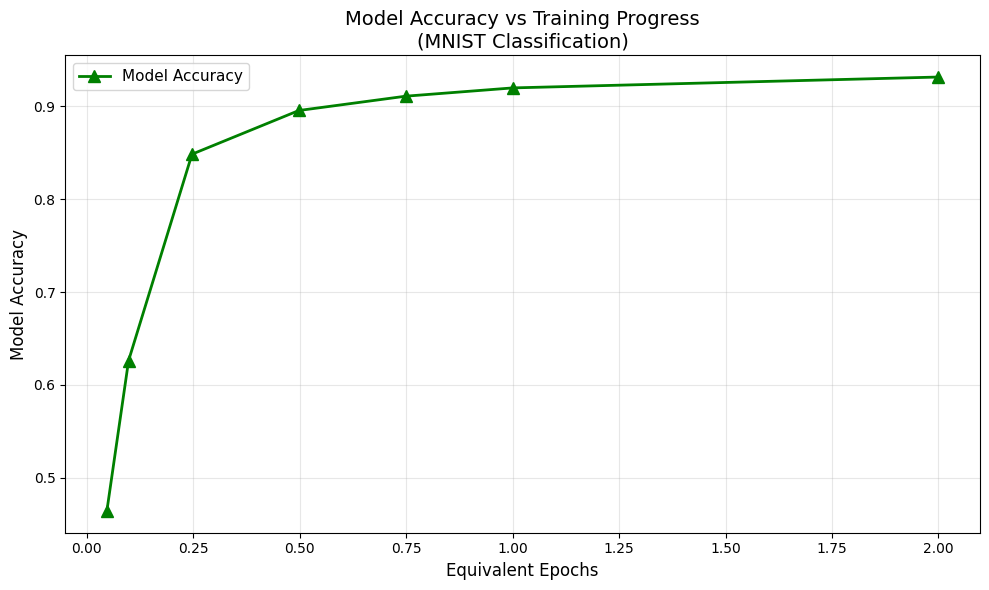

Secondary plot saved as 'mnist_accuracy_vs_epochs.png'


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28)
        self.fc2 = nn.Linear(28, 28)
        self.fc3 = nn.Linear(28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, training_steps=100):
    """Train model for a specified number of steps instead of epochs"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    model.to(device)
    
    step_count = 0
    data_iter = iter(train_loader)
    
    while step_count < training_steps:
        try:
            data, target = next(data_iter)
        except StopIteration:
            # Reset iterator when we reach end of dataset
            data_iter = iter(train_loader)
            data, target = next(data_iter)
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        step_count += 1
        
        # Optional: print progress every 100 steps
        if step_count % 100 == 0:
            print(f"  Step {step_count}/{training_steps} completed")

def evaluate_model_accuracy(model, data_loader):
    """Calculate overall model accuracy on the dataset"""
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    
    return correct / total

def get_train_loader(batch_size=256):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    loader_kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **loader_kwargs)
    return train_loader

def get_test_loader(batch_size=256):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    loader_kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
    
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **loader_kwargs)
    return test_loader

def extract_activations_and_losses(model, data_loader):
    model.eval()
    model.to(device)
    all_activations = []
    all_losses = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            x = data.view(-1, 28 * 28)
            h1 = F.relu(model.fc1(x))
            h2 = F.relu(model.fc2(h1))
            output = model.fc3(h2)

            h1_binary = (h1 > 0).float()
            h2_binary = (h2 > 0).float()

            losses = F.cross_entropy(output, target, reduction='none')
            activation_pattern = torch.cat([h1_binary, h2_binary], dim=1)
            all_activations.append(activation_pattern.cpu())
            all_losses.append(losses)
    
    return torch.cat(all_activations).numpy(), torch.cat(all_losses).numpy()

def extract_activations_and_correctness(model, data_loader):
    model.eval()
    model.to(device)
    all_activations = []
    all_correctness = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            x = data.view(-1, 28 * 28)
            h1 = F.relu(model.fc1(x))
            h2 = F.relu(model.fc2(h1))
            output = model.fc3(h2)

            h1_binary = (h1 > 0).float()
            h2_binary = (h2 > 0).float()

            predictions = torch.argmax(output, dim=1)
            is_correct = (predictions == target).float()
            activation_pattern = torch.cat([h1_binary, h2_binary], dim=1)
            all_activations.append(activation_pattern.cpu())
            all_correctness.append(is_correct.cpu())
    
    return torch.cat(all_activations).numpy(), torch.cat(all_correctness).numpy()

def extract_output_logits(model, data_loader):
    model.eval()
    model.to(device)
    outputs = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            x = data.view(-1, 28 * 28)
            h1 = F.relu(model.fc1(x))
            h2 = F.relu(model.fc2(h1))
            output = model.fc3(h2)

            outputs.append(output)
    
    return torch.cat(outputs).numpy()

def find_threshold_for_accuracy(predictions, correctness_labels, target_accuracy=0.99, method='loss'):
    """
    Find threshold that achieves target accuracy on confident predictions.
    
    Args:
        predictions: Array of predictions (loss predictions or max logits)
        correctness_labels: Binary array indicating if prediction was correct
        target_accuracy: Desired accuracy on confident predictions (e.g., 0.99)
        method: 'loss' for loss predictions (lower is better) or 'logit' for logits (higher is better)
    
    Returns:
        threshold: Threshold value that achieves target accuracy
        actual_accuracy: Actual accuracy achieved
        coverage: Fraction of samples that are "confident"
    """
    
    if method == 'loss':
        # For loss predictions, sort ascending (lower loss = more confident)
        sorted_indices = np.argsort(predictions)
    else:  # method == 'logit'
        # For logit predictions, sort descending (higher logit = more confident)
        sorted_indices = np.argsort(predictions)[::-1]
    
    sorted_correctness = correctness_labels[sorted_indices]
    sorted_predictions = predictions[sorted_indices]
    
    # Find the largest subset where accuracy >= target_accuracy
    best_threshold = None
    best_accuracy = 0
    best_coverage = 0
    
    for i in range(1, len(sorted_correctness) + 1):
        current_accuracy = np.mean(sorted_correctness[:i])
        
        if current_accuracy >= target_accuracy:
            # Found a valid threshold, keep expanding
            best_threshold = sorted_predictions[i-1]
            best_accuracy = current_accuracy
            best_coverage = i / len(sorted_correctness)
        elif best_threshold is not None:
            # Accuracy dropped below target, stop here
            break
    
    if best_threshold is None:
        print(f"Warning: Could not achieve target accuracy of {target_accuracy}")
        # Return most restrictive threshold
        best_threshold = sorted_predictions[0]
        best_accuracy = sorted_correctness[0]
        best_coverage = 1 / len(sorted_correctness)
    
    return best_threshold, best_accuracy, best_coverage

# Calculate steps per epoch for reference
train_loader = get_train_loader()
steps_per_epoch = len(train_loader)
print(f"Dataset has {len(train_loader.dataset)} training samples")
print(f"With batch size {train_loader.batch_size}, there are {steps_per_epoch} steps per epoch")

# Main training loop for different training steps
# Convert your original epoch values to approximate step counts
training_steps_list = [
    int(0.05 * steps_per_epoch),   # ~12 steps
    int(0.1 * steps_per_epoch),    # ~23 steps  
    int(0.25 * steps_per_epoch),   # ~59 steps
    int(0.5 * steps_per_epoch),    # ~117 steps
    int(0.75 * steps_per_epoch),   # ~176 steps
    int(1.0 * steps_per_epoch),    # ~234 steps (1 full epoch)
    int(2.0 * steps_per_epoch),    # ~469 steps (2 full epochs)
]

model_accuracies = []
lgb_coverages = []
baseline_coverages = []
target_accuracy = 0.99

# Get data loaders once
test_loader = get_test_loader()

# LightGBM parameters
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': ['rmse', 'mae'],
    
    # Tree structure - more complex for better fitting
    'max_depth': -1,
    'num_leaves': 4096,
    'min_data_in_leaf': 1,
    'min_sum_hessian_in_leaf': 1e-6,
    'min_gain_to_split': 0.0,
    
    # Feature selection - use all features aggressively
    'feature_fraction': 1.0,
    'feature_fraction_bynode': 1.0,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    
    # Learning parameters - slower but more thorough
    'learning_rate': 0.005,
    
    # Regularization - lighter since we want to fit well
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
    'alpha': 0.9,
    
    # Computational
    'num_threads': -1,
    'force_row_wise': True,
    'verbosity': -1,  # Suppress output
    'seed': 42,
    'deterministic': True,
    
    # Advanced options for better performance
    'boost_from_average': True,
    'is_unbalance': False,
    'max_bin': 511,
    'bin_construct_sample_cnt': 200000,
}

for training_steps in training_steps_list:
    equivalent_epochs = training_steps / steps_per_epoch
    print(f"\n{'='*50}")
    print(f"Training model for {training_steps} steps (~{equivalent_epochs:.2f} epochs)...")
    print(f"{'='*50}")
    
    # Initialize and train model
    model = SimpleNN()
    train_model(model, train_loader, training_steps=training_steps)
    
    # Calculate model accuracy
    model_accuracy = evaluate_model_accuracy(model, test_loader)
    model_accuracies.append(model_accuracy)
    
    # Extract training data for LightGBM
    activations, losses = extract_activations_and_losses(model, train_loader)
    
    # Split data for LightGBM training and validation
    X_test, X_stop_test, y_test, y_stop_test = train_test_split(
        activations, 
        losses, 
        test_size=0.1,
        random_state=42
    )
    test_data = lgb.Dataset(X_test, label=y_test)
    stop_test_data = lgb.Dataset(X_stop_test, label=y_stop_test, reference=test_data)
    
    print(f"Building LightGBM model with {len(activations)} samples...")
    start_time = time.time()
    
    # Train LightGBM model
    model_lgb = lgb.train(
        params, 
        test_data, 
        num_boost_round=5000,
        valid_sets=[stop_test_data],
        valid_names=['stop_test_data'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.reset_parameter(learning_rate=lambda iter: 0.005 * (0.99 ** (iter // 100)))
        ]
    )
    
    print(f"LightGBM model built in {time.time() - start_time:.2f} seconds")
    
    # Extract test data
    test_activations, test_correctness_labels = extract_activations_and_correctness(model, test_loader)
    test_activations_losses, test_losses = extract_activations_and_losses(model, test_loader)
    test_outputs = extract_output_logits(model, test_loader)
    
    # Evaluate LightGBM (Binary Tree) coverage
    validation_loss_predictions = model_lgb.predict(test_activations)
    low_loss_threshold, actual_accuracy, lgb_coverage = find_threshold_for_accuracy(
        validation_loss_predictions, test_correctness_labels, target_accuracy, method='loss'
    )
    
    # Evaluate baseline (max logits) coverage
    test_max_logits = np.array([max(output) for output in test_outputs])
    logit_threshold, logit_accuracy, baseline_coverage = find_threshold_for_accuracy(
        test_max_logits, test_correctness_labels, target_accuracy, method='logit'
    )
    
    # Store results
    lgb_coverages.append(lgb_coverage)
    baseline_coverages.append(baseline_coverage)
    
    # Print results for this training run
    print(f"Results for {training_steps} steps (~{equivalent_epochs:.2f} epochs):")
    print(f"  Model Accuracy: {model_accuracy:.4f}")
    print(f"  LightGBM Coverage: {lgb_coverage:.3f}")
    print(f"  Baseline Coverage: {baseline_coverage:.3f}")

# Create the comparison plot - Model Accuracy vs Coverage
plt.figure(figsize=(10, 6))
plt.plot(model_accuracies, baseline_coverages, 'b-o', label='Baseline Coverage (Max Logits)', linewidth=2, markersize=8)
plt.plot(model_accuracies, lgb_coverages, 'r-s', label='Binary Tree Coverage (LightGBM)', linewidth=2, markersize=8)

plt.xlabel('Model Accuracy', fontsize=12)
plt.ylabel('Coverage at 99% Accuracy', fontsize=12)
plt.title('Model Accuracy vs Coverage Comparison\n(MNIST Classification)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add some styling
plt.tight_layout()
plt.ylim(0, max(max(baseline_coverages), max(lgb_coverages)) * 1.1)
plt.xlim(min(model_accuracies) * 0.95, max(model_accuracies) * 1.02)

# Print final summary
print(f"\n{'='*70}")
print("FINAL SUMMARY")
print(f"{'='*70}")
print("Steps | Equiv Epochs | Model Accuracy | Baseline Coverage | Binary Tree Coverage | Difference")
print("-" * 80)
for i, training_steps in enumerate(training_steps_list):
    equivalent_epochs = training_steps / steps_per_epoch
    diff = lgb_coverages[i] - baseline_coverages[i]
    print(f"{training_steps:5d} | {equivalent_epochs:10.2f} | {model_accuracies[i]:13.4f} | {baseline_coverages[i]:15.3f} | {lgb_coverages[i]:18.3f} | {diff:+9.3f}")

plt.show()

# Also save the plot
plt.savefig('mnist_accuracy_vs_coverage_comparison.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as 'mnist_accuracy_vs_coverage_comparison.png'")

# Also create a secondary plot showing training steps vs accuracy for reference
equivalent_epochs_list = [steps / steps_per_epoch for steps in training_steps_list]
plt.figure(figsize=(10, 6))
plt.plot(equivalent_epochs_list, model_accuracies, 'g-^', label='Model Accuracy', linewidth=2, markersize=8)
plt.xlabel('Equivalent Epochs', fontsize=12)
plt.ylabel('Model Accuracy', fontsize=12)
plt.title('Model Accuracy vs Training Progress\n(MNIST Classification)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mnist_accuracy_vs_epochs.png', dpi=300, bbox_inches='tight')
plt.show()
print("Secondary plot saved as 'mnist_accuracy_vs_epochs.png'")

In [48]:
import numpy as np
def extract_activations_and_correctness(model, data_loader):
    model.eval()
    model.to(device)
    all_activations = []
    all_correctness = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            x = data.view(-1, 28 * 28)
            h1 = F.relu(model.fc1(x))
            h2 = F.relu(model.fc2(h1))
            output = model.fc3(h2)

            h1_binary = (h1 > 0).float()
            h2_binary = (h2 > 0).float()


            predictions = torch.argmax(output, dim=1)
            is_correct = (predictions == target).float()
            activation_pattern = torch.cat([h1_binary, h2_binary], dim=1)
            all_activations.append(activation_pattern.cpu())
            all_correctness.append(is_correct.cpu())
    
    return torch.cat(all_activations).numpy(), torch.cat(all_correctness).numpy()

def get_test_loader(batch_size=256):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    loader_kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
    
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **loader_kwargs)
    return test_loader

test_loader = get_test_loader()
test_activations, test_correctness_labels = extract_activations_and_correctness(model, test_loader)
test_activations, test_losses = extract_activations_and_losses(model, test_loader)

validation_loss_predictions = model_lgb.predict(test_activations)
low_loss_threshold = 0.0735
confident_mask = validation_loss_predictions < low_loss_threshold
confident_correctness_labels = test_correctness_labels[confident_mask]
confident_accuracy = np.mean(confident_correctness_labels)

print(f"Coverage of confident predictions: {np.mean(confident_mask):.3f} ({np.sum(confident_mask)}/{len(test_activations)} validation samples)")
print(f"Accuracy on confident predictions: {np.mean(confident_correctness_labels):.4f}")
print(f"Model's true validation accuracy: {np.sum(test_correctness_labels) / len(test_correctness_labels):.4f}")


Coverage of confident predictions: 0.167 (1666/10000 validation samples)
Accuracy on confident predictions: 1.0000
Model's true validation accuracy: 0.9527


In [4]:
import numpy as np
def extract_output_logits(model, data_loader):
    model.eval()
    model.to(device)
    outputs = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            x = data.view(-1, 28 * 28)
            h1 = F.relu(model.fc1(x))
            h2 = F.relu(model.fc2(h1))
            output = model.fc3(h2)

            outputs.append(output)
    
    return torch.cat(outputs).numpy()

def get_test_loader(batch_size=256):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    loader_kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
    
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **loader_kwargs)
    return test_loader

test_loader = get_test_loader()
test_outputs = extract_output_logits(model, test_loader)

confident_outputs_mask = np.array([max(output) > 10.2 for output in test_outputs])
confident_outputs_test_labels = test_correctness_labels[confident_outputs_mask]
outputs_coverage = np.mean(confident_outputs_mask)
print(f"Baseline coverage of confident NAPs: {outputs_coverage:.3f}")
print(f"Baseline Accuracy on confident predictions (how often model gets answer right): {np.sum(confident_outputs_test_labels) / len(confident_outputs_test_labels):.4f}")
print(f"Baseline Model's true test accuracy (how often model gets answer right): {np.sum(test_correctness_labels) / len(test_correctness_labels):.4f}")

Baseline coverage of confident NAPs: 0.151
Baseline Accuracy on confident predictions (how often model gets answer right): 1.0000
Baseline Model's true test accuracy (how often model gets answer right): 0.9573
